In [ ]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

print("PyTorch version:", torch.__version__)
print("CUDA is available:", torch.cuda.is_available())

!git clone https://github.com/SysCV/sam-hq.git
os.chdir('sam-hq')
!export PYTHONPATH=$(pwd)
from segment_anything import sam_model_registry, SamPredictor


PyTorch version: 2.0.1+cu118
CUDA is available: True
Cloning into 'sam-hq'...
remote: Enumerating objects: 122, done.
remote: Counting objects: 100% (122/122), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 122 (delta 32), reused 104 (delta 23), pack-reused 0
Receiving objects: 100% (122/122), 32.97 MiB | 18.83 MiB/s, done.
Resolving deltas: 100% (32/32), done.


In [ ]:
!mkdir pretrained_checkpoint
!wget https://huggingface.co/lkeab/hq-sam/resolve/main/sam_hq_vit_l.pth
!mv sam_hq_vit_l.pth pretrained_checkpoint


--2023-06-13 10:43:04--  https://huggingface.co/lkeab/hq-sam/resolve/main/sam_hq_vit_l.pth
Resolving huggingface.co (huggingface.co)... 52.84.162.18, 52.84.162.46, 52.84.162.85, ...
Connecting to huggingface.co (huggingface.co)|52.84.162.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/d9/4e/d94e04992ac4e3ea45fcc1c523974540cdbef274e295d4aaacc69b4f19ee63b7/e1a6c385d62bf005ded91a54d5ec55c985cfc4103ef89c08d90f39f04934c343?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27sam_hq_vit_l.pth%3B+filename%3D%22sam_hq_vit_l.pth%22%3B&Expires=1686912184&Policy=eyJTdGF0ZW1lbnQiOlt7IlJlc291cmNlIjoiaHR0cHM6Ly9jZG4tbGZzLmh1Z2dpbmdmYWNlLmNvL3JlcG9zL2Q5LzRlL2Q5NGUwNDk5MmFjNGUzZWE0NWZjYzFjNTIzOTc0NTQwY2RiZWYyNzRlMjk1ZDRhYWFjYzY5YjRmMTllZTYzYjcvZTFhNmMzODVkNjJiZjAwNWRlZDkxYTU0ZDVlYzU1Yzk4NWNmYzQxMDNlZjg5YzA4ZDkwZjM5ZjA0OTM0YzM0Mz9yZXNwb25zZS1jb250ZW50LWRpc3Bvc2l0aW9uPSoiLCJDb25kaXRpb24iOnsiRGF0ZUxlc3NUaGFuIjp7IkFXUzpFcG

In [ ]:

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))


def show_res(masks, scores, input_point, input_label, input_box, image):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10,10))
        plt.imshow(image)
        show_mask(mask, plt.gca())
        if input_box is not None:
            box = input_box[i]
            show_box(box, plt.gca())
        if (input_point is not None) and (input_label is not None):
            show_points(input_point, input_label, plt.gca())

        print(f"Score: {score:.3f}")
        plt.axis('off')
        plt.show()


def show_res_multi(masks, scores, input_point, input_label, input_box, image):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    for mask in masks:
        show_mask(mask, plt.gca(), random_color=True)
    for box in input_box:
        show_box(box, plt.gca())
    for score in scores:
        print(f"Score: {score:.3f}")
    plt.axis('off')
    plt.show()


In [ ]:
sam_checkpoint = "pretrained_checkpoint/sam_hq_vit_l.pth"
model_type = "vit_l"
device = "cuda"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)

<All keys matched successfully>


Score: 0.894


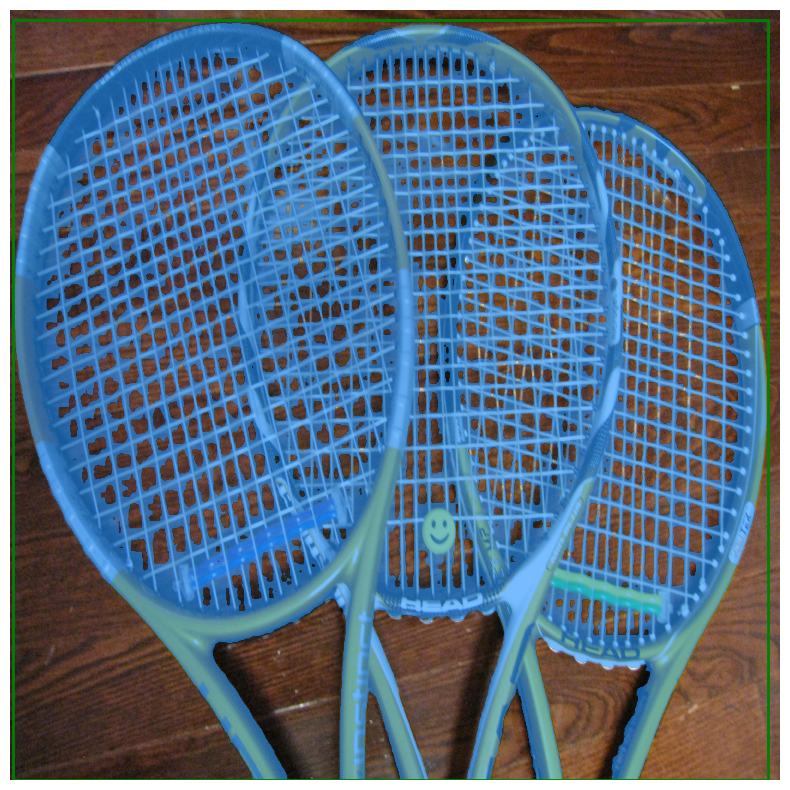

In [ ]:
image = cv2.imread('demo/input_imgs/example0.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
input_box = np.array([[4,13,1007,1023]])
input_point, input_label = None, None
predictor.set_image(image)
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box = input_box,
    multimask_output=False,
    hq_token_only= False,
)
show_res(masks,scores,input_point, input_label, input_box, image)

Score: 0.891


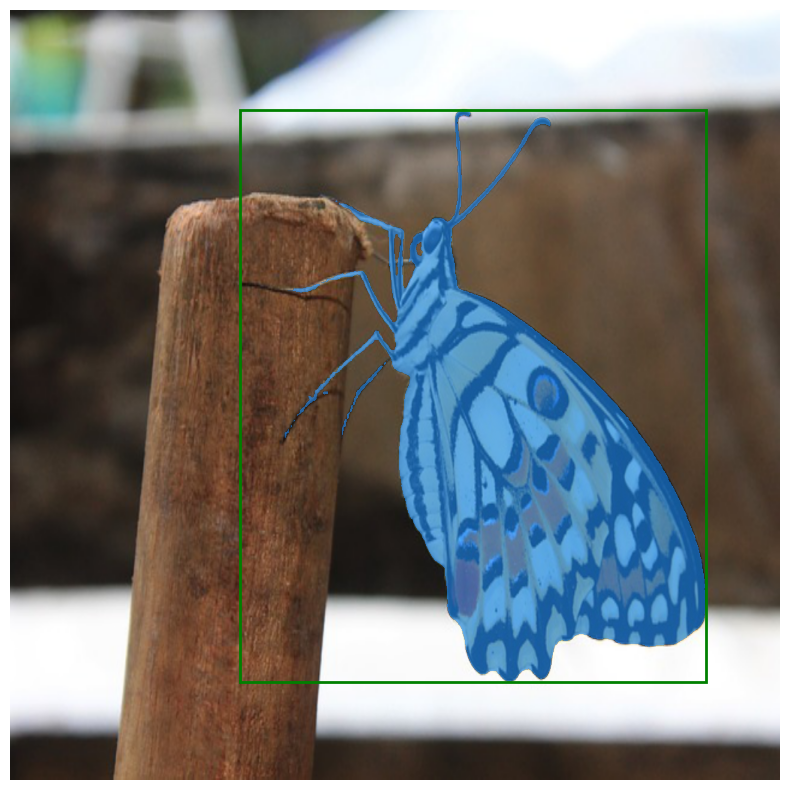

In [ ]:
image = cv2.imread('demo/input_imgs/example1.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
input_box = np.array([[306, 132, 925, 893]])
input_point, input_label = None, None
predictor.set_image(image)
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box = input_box,
    multimask_output=False,
    hq_token_only= True,
)
show_res(masks,scores,input_point, input_label, input_box, image)

Score: 0.920


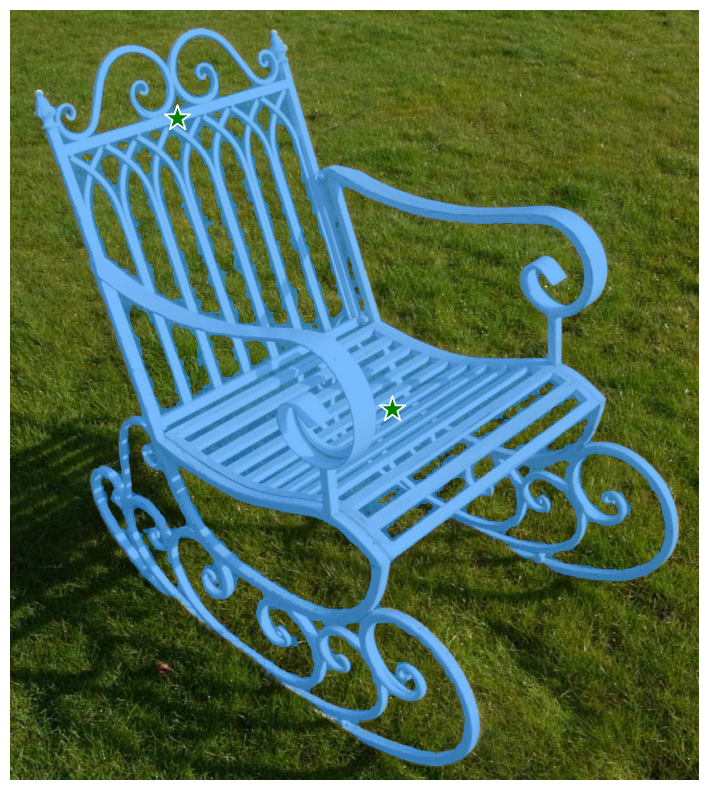

In [ ]:
image = cv2.imread('demo/input_imgs/example2.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
input_point = np.array([[495,518],[217,140]])
input_label = np.ones(input_point.shape[0])
input_box = None
predictor.set_image(image)
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box = input_box,
    multimask_output=False,
    hq_token_only= True,
)
show_res(masks,scores,input_point, input_label, input_box, image)

Score: 0.911


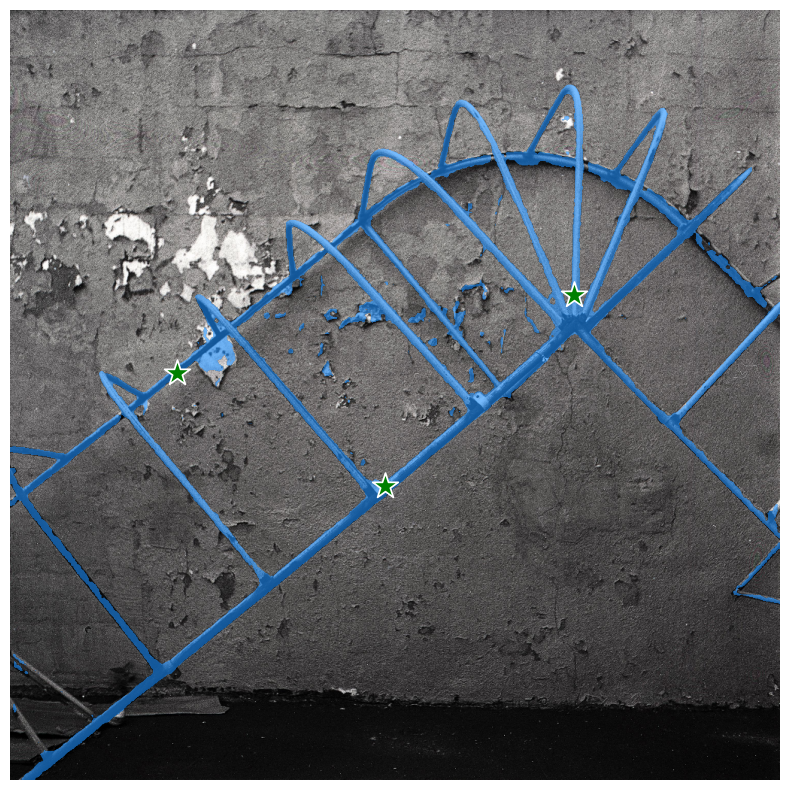

In [ ]:
image = cv2.imread('demo/input_imgs/example3.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
input_point = np.array([[221,482],[498,633],[750,379]])
input_label = np.ones(input_point.shape[0])
input_box = None
predictor.set_image(image)
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box = input_box,
    multimask_output=False,
    hq_token_only= False,
)
show_res(masks,scores,input_point, input_label, input_box, image)

Score: 0.973


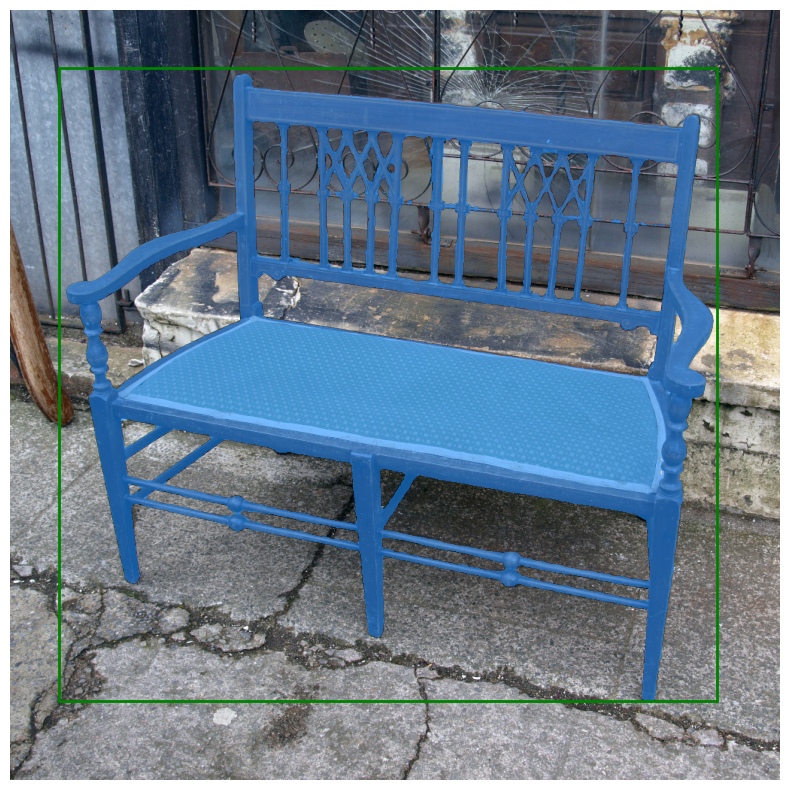

In [ ]:
image = cv2.imread('demo/input_imgs/example4.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
input_box = np.array([[64,76,940,919]])
input_point, input_label = None, None
predictor.set_image(image)
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box = input_box,
    multimask_output=False,
    hq_token_only= True,
)
show_res(masks,scores,input_point, input_label, input_box, image)

Score: 0.967


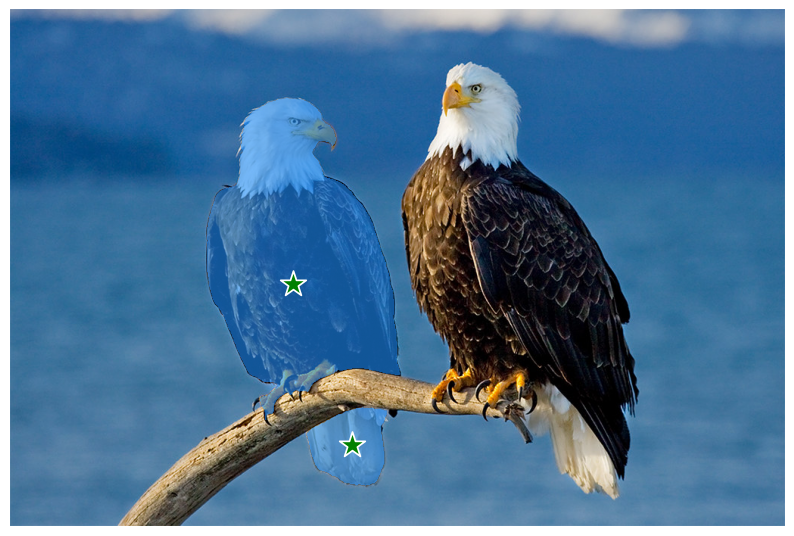

In [ ]:
image = cv2.imread('demo/input_imgs/example5.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
input_point = np.array([[373,363], [452, 575]])
input_label = np.ones(input_point.shape[0])
input_box = None
predictor.set_image(image)
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box = input_box,
    multimask_output=False,
    hq_token_only= False,
)
show_res(masks,scores,input_point, input_label, input_box, image)

Score: 0.990


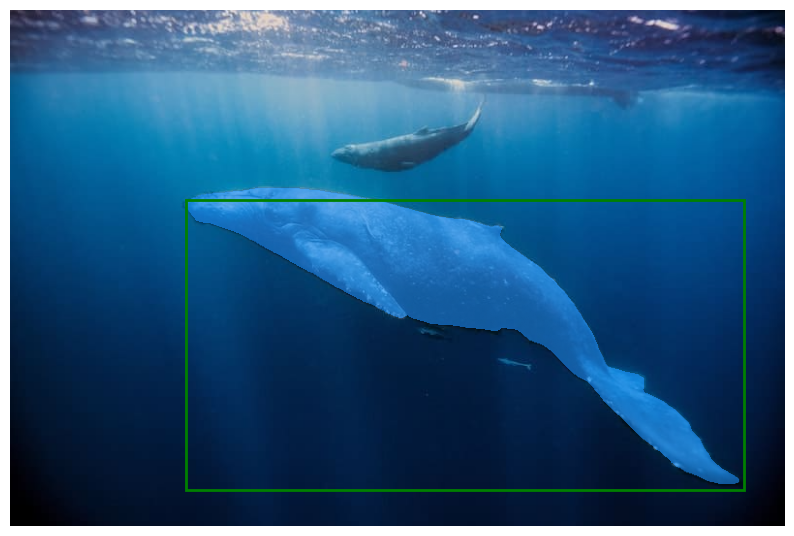

In [ ]:
image = cv2.imread('demo/input_imgs/example6.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
input_box = np.array([[181, 196, 757, 495]])
input_point, input_label = None, None
predictor.set_image(image)
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box = input_box,
    multimask_output=False,
    hq_token_only= False,
)
show_res(masks,scores,input_point, input_label, input_box, image)

Score: 0.715
Score: 0.968


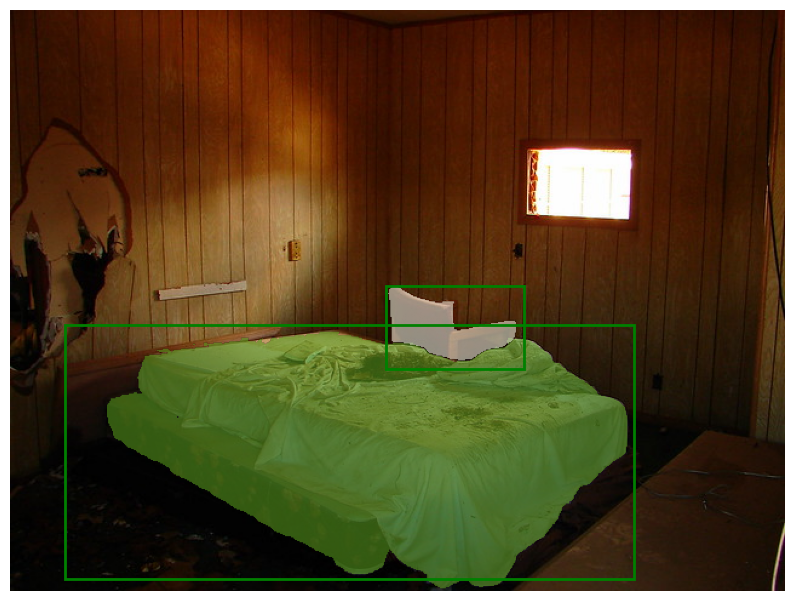

In [ ]:
image = cv2.imread('demo/input_imgs/example7.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# multi box input
input_box = torch.tensor([[45,260,515,470], [310,228,424,296]],device=predictor.device)
transformed_box = predictor.transform.apply_boxes_torch(input_box, image.shape[:2])
input_point, input_label = None, None
predictor.set_image(image)
masks, scores, logits = predictor.predict_torch(
    point_coords=input_point,
    point_labels=input_label,
    boxes=transformed_box,
    multimask_output=False,
    hq_token_only=False,
)
masks = masks.squeeze(1).cpu().numpy()
scores = scores.squeeze(1).cpu().numpy()
input_box = input_box.cpu().numpy()
show_res_multi(masks, scores, input_point, input_label, input_box, image)